In [1]:
import pandas as pd

In [2]:
from camera_entity_lib_org import *
from typing import Dict, Any

In [3]:
resolver = CameraEntityResolver(
    use_cache=True, 
) 

In [13]:
# def flatten_json(d: Dict[str, Any], parent_key: str = "", sep: str = ".") -> Dict[str, Any]:
#     items = {}
#     for k, v in d.items():
#         new_key = f"{parent_key}{sep}{k}" if parent_key else k
#         if isinstance(v, dict):
#             items.update(flatten_json(v, new_key, sep=sep))
#         else:
#             items[new_key] = v
#     return items

# json_path= "camera/camera_specs/www.ebay.com/56747.json"
# with open(json_path, "r", encoding="utf-8") as f:
#         raw_spec = json.load(f)

# # flat_spec = flatten_json(raw_spec)

# c_id = resolver.resolve_from_dict(raw_spec)
# c_id

'ENTITY#85'

In [4]:
df = resolver.gt_df  

# 1) One random spec_id per entity_id
per_entity = (
    df.groupby("entity_id", group_keys=False)
      .sample(n=1, random_state=42)        # 1 random row per entity
)

# 2) From those unique-entity rows, pick 50 entities
n = min(50, len(per_entity))              # safety if you have < 50 entities
sampled = per_entity.sample(n=n, random_state=42)

spec_ids_to_test   = sampled["spec_id"].tolist()
entity_ids_to_test = sampled["entity_id"].tolist()  

In [14]:
from tqdm import tqdm
import numpy as np
import pandas as pd
import re
from difflib import SequenceMatcher

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# -------------------------
# Setup canonical corpus
# -------------------------
gt_df = resolver.gt_df

canon_df = resolver.canonical_df.copy()
canon_df["entity_id"] = canon_df["entity_id"].astype(str)
canon_ids = canon_df["entity_id"].tolist()
canon_texts = canon_df["canonical_sig"].fillna("").astype(str).tolist()

# -------------------------
# TF-IDF (fit once)
# -------------------------
tfidf_vec = TfidfVectorizer(lowercase=True, ngram_range=(1, 2), max_features=50000)
X_canon = tfidf_vec.fit_transform(canon_texts)

def tfidf_top1(query_text: str):
    q = tfidf_vec.transform([query_text])
    sims = cosine_similarity(q, X_canon).ravel()
    idx = int(np.argmax(sims))
    return canon_ids[idx], float(sims[idx])

# -------------------------
# Jaccard (precompute once)
# -------------------------
_tok_re = re.compile(r"[a-z0-9]+")
def tokenize(s: str):
    return set(_tok_re.findall(str(s).lower()))

canon_tokens = [tokenize(t) for t in canon_texts]

def jaccard_top1(query_text: str):
    q = tokenize(query_text)
    best_eid, best = None, -1.0
    if not q:
        return "NEW_ENTITY", 0.0
    for eid, toks in zip(canon_ids, canon_tokens):
        if not toks:
            s = 0.0
        else:
            s = len(q & toks) / len(q | toks)
        if s > best:
            best, best_eid = s, eid
    return best_eid, float(best)

# -------------------------
# Edit similarity (no precompute needed)
# -------------------------
def edit_top1(query_text: str):
    q = str(query_text).lower()
    best_eid, best = None, -1.0
    for eid, txt in zip(canon_ids, canon_texts):
        s = SequenceMatcher(None, q, str(txt).lower()).ratio()
        if s > best:
            best, best_eid = s, eid
    return best_eid, float(best)

# -------------------------
# Optional thresholds to allow NEW_ENTITY
# -------------------------
TFIDF_MIN = 0.10     # set 0.0 to always link
JACC_MIN  = 0.05     # set 0.0 to always link
EDIT_MIN  = 0.40     # set 0.0 to always link

# SBERT uses resolver.sim_min already via resolver.resolve_from_dict()

# -------------------------
# Evaluation loop
# -------------------------
rows = []

for spec_id in tqdm(spec_ids_to_test, desc="Fair comparison"):
    row = gt_df[gt_df["spec_id"] == spec_id]
    if row.empty:
        continue
    true_eid = str(row["entity_id"].iloc[0])

    spec = resolver.load_spec_id(spec_id)
    record_sig, _ = spec_to_record_text(spec)   # same query text for ALL methods

    # 1) SBERT (embedding)
    pred_sbert = str(resolver.resolve_from_dict(spec))  # returns eid or NEW_ENTITY

    # 2) TF-IDF (no embeddings)
    eid_tfidf, s_tfidf = tfidf_top1(record_sig)
    pred_tfidf = eid_tfidf if s_tfidf >= TFIDF_MIN else "NEW_ENTITY"

    # 3) Jaccard (no embeddings)
    eid_jacc, s_jacc = jaccard_top1(record_sig)
    pred_jacc = eid_jacc if s_jacc >= JACC_MIN else "NEW_ENTITY"


    rows.append({
        "spec_id": spec_id,
        "true_eid": true_eid,

        "pred_sbert": pred_sbert,

        "pred_tfidf": pred_tfidf,
        "score_tfidf": s_tfidf,

        "pred_jacc": pred_jacc,
        "score_jacc": s_jacc,

    })

res_df = pd.DataFrame(rows)

def er_metrics(true_eid, pred_eid):
    correct = (true_eid == pred_eid)
    acc = float(np.mean(correct))

    # binary precision/recall/f1 where positive = correct match
    tp = int(np.sum(correct))
    fn = int(len(correct) - tp)
    fp = 0  # there are no "true negatives" in this setup
    precision = tp / (tp + fp) if (tp + fp) else 0.0
    recall    = tp / (tp + fn) if (tp + fn) else 0.0
    f1        = (2*precision*recall/(precision+recall)) if (precision+recall) else 0.0

    # coverage = float(np.mean(pred_eid != "NEW_ENTITY"))  # how often it links to an existing entity
    # known_mask = (pred_eid != "NEW_ENTITY")
    known_acc = float(np.mean((true_eid[known_mask] == pred_eid[known_mask]))) if np.any(known_mask) else 0.0

    return {
        "n": int(len(true_eid)),
        "accuracy": acc,
        "precision": float(precision),
        "recall": float(recall),
        "f1": float(f1),
        # "coverage_linked": coverage,
        # "known_only_accuracy": known_acc,
    }

y_true = res_df["true_eid"].to_numpy()

summary = pd.DataFrame([
    {"method": "SBERT_cosine", **er_metrics(y_true, res_df["pred_sbert"].to_numpy())},
    {"method": "TFIDF_cosine", **er_metrics(y_true, res_df["pred_tfidf"].to_numpy())},
    {"method": "Jaccard",     **er_metrics(y_true, res_df["pred_jacc"].to_numpy())},
    # {"method": "EditSim",     **er_metrics(y_true, res_df["pred_edit"].to_numpy())},
])

print(summary.sort_values("accuracy", ascending=False))

Fair comparison: 100%|█████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 59.62it/s]

         method   n  accuracy  precision  recall        f1
0  SBERT_cosine  50      0.94        1.0    0.94  0.969072
1  TFIDF_cosine  50      0.50        1.0    0.50  0.666667
2       Jaccard  50      0.46        1.0    0.46  0.630137


In [15]:
summary

,method,n,accuracy,precision,recall,f1
0,SBERT_cosine,50,0.94,1.0,0.94,0.969072
1,TFIDF_cosine,50,0.50,1.0,0.50,0.666667
2,Jaccard,50,0.46,1.0,0.46,0.630137


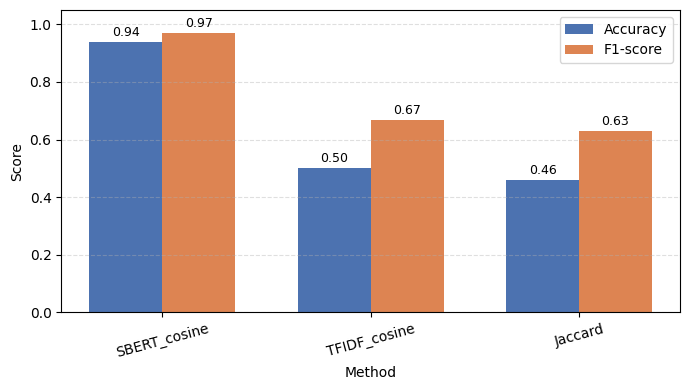

In [20]:
import numpy as np
import matplotlib.pyplot as plt

methods = summary["method"].tolist()
accuracy = summary["accuracy"].values
f1 = summary["f1"].values

x = np.arange(len(methods))
width = 0.35

plt.figure(figsize=(7, 4))

bars_acc = plt.bar(
    x - width/2,
    accuracy,
    width,
    label="Accuracy",
    color="#4C72B0"   # blue
)

bars_f1 = plt.bar(
    x + width/2,
    f1,
    width,
    label="F1-score",
    color="#DD8452"   # orange
)

plt.xticks(x, methods, rotation=15)
plt.ylim(0, 1.05)
plt.ylabel("Score")
plt.xlabel("Method")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.4)

# ---- add value labels ----
def add_labels(bars):
    for b in bars:
        h = b.get_height()
        plt.text(
            b.get_x() + b.get_width() / 2,
            h + 0.01,
            f"{h:.2f}",
            ha="center",
            va="bottom",
            fontsize=9
        )

add_labels(bars_acc)
add_labels(bars_f1)

plt.tight_layout()
plt.savefig("entity_resolution_accuracy_f1.png", dpi=300, bbox_inches="tight")
plt.show()

In [ ]:
# def flatten_json(d: Dict[str, Any], parent_key: str = "", sep: str = ".") -> Dict[str, Any]:
#     items = {}
#     for k, v in d.items():
#         new_key = f"{parent_key}{sep}{k}" if parent_key else k
#         if isinstance(v, dict):
#             items.update(flatten_json(v, new_key, sep=sep))
#         else:
#             items[new_key] = v
#     return items

# json_path= "camera/camera_specs/www.ebay.com/56747.json"
# with open(json_path, "r", encoding="utf-8") as f:
#         raw_spec = json.load(f)

# # flat_spec = flatten_json(raw_spec)

# c_id = resolver.resolve_from_dict(raw_spec)
# c_id

In [ ]:
screen_size, mega_pixel, batterty_type, price, storage

In [55]:
# ====== JUPYTER NOTEBOOK: Evaluation (3 methods) ======
# Methods:
#   1) entity + LLM (your DataImputationEngine)          :contentReference[oaicite:0]{index=0}
#   2) entity-mode (no LLM)
#   3) kNN-mode (no entity)

import os, json, re
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from imputation_lib import ImputationConfig, DataImputationEngine


# -----------------------------
# 0) EDIT THESE PATHS
# -----------------------------
ENTITY_DF_PATH = "entity_clean.csv"

# for megapixel
JSON_DIR = "target_data_megapixel"
GT_CSV = "gt_mega.xlsx"
GT_ID_COL = "id"
GT_VALUE_COL = "mega_pixel"      # column in gt_mega.csv
FIELD_NAME_FOR_ENGINE = "mega_pixel"   # what you pass to engine.impute(...)
ENTITY_FIELD_COL = "mega_pixel"     

# JSON_DIR = "target_data_screen_size"
# GT_CSV = "gt_size.xlsx"
# GT_ID_COL = "id"
# GT_VALUE_COL = "screen_size"
# # ENTITY_FIELD_COL = "screen_size"

# FIELD_NAME_FOR_ENGINE = "screen_size"   # what you pass to engine.impute(...)
# ENTITY_FIELD_COL = "screen_size"   

# resolver must exist in your notebook already:
# e.g. resolver = YourResolver(...)
# and must have: resolver.resolve_from_dict(raw_json)

FIELD_ALIASES = {
    "mega_pixel": [
        "mega_pixel", "megapixel", "megaPixel", "MegaPixel",
        "megapixels", "mega_pixels", "mp", "resolution",
        "imageResolution", "image_resolution", "image.resolution"
    ],
    "screen_size": [
        "screen_size", "screenSize", "display_size", "displaySize",
        "screen", "display", "lcd_size", "lcdSize", "inch"
    ]
}
def resolve_entity_columns(entity_df: pd.DataFrame, field_name: str):
    """
    Returns list of matching column names in entity_df
    for a canonical field_name (e.g. mega_pixel).
    """
    aliases = FIELD_ALIASES.get(field_name, [])
    cols = []

    for c in entity_df.columns:
        cl = c.lower()
        for a in aliases:
            if a.lower() in cl:
                cols.append(c)
                break

    return cols

# -----------------------------
# Helpers
# -----------------------------
def flatten_json(d, parent_key="", sep="."):
    items = {}
    for k, v in d.items():
        new_key = f"{parent_key}{sep}{k}" if parent_key else k
        if isinstance(v, dict):
            items.update(flatten_json(v, new_key, sep=sep))
        else:
            items[new_key] = v
    return items

def parse_float(x):
    if x is None:
        return None
    s = str(x).lower().strip()
    if not s or s in {"nan", "none", "null"}:
        return None
    m = re.search(r"[-+]?\d+(\.\d+)?", s)
    if not m:
        return None
    try:
        return float(m.group())
    except:
        return None

def safe_mode(values):
    vals = []
    for v in values:
        if v is None:
            continue
        s = str(v).strip()
        if not s or s.lower() in {"nan","none","null"}:
            continue
        vals.append(s)
    if not vals:
        return None
    return Counter(vals).most_common(1)[0][0]

def build_text_for_knn(flat: dict):
    parts = []
    for k, v in flat.items():
        if v is None:
            continue
        kl = k.lower()
        if any(t in kl for t in ["brand","manufacturer","make","product","model","name","title","series"]):
            parts.append(f"{k}:{v}")
    if not parts:
        for i, (k, v) in enumerate(flat.items()):
            if i >= 30:
                break
            if v is None:
                continue
            parts.append(f"{k}:{v}")
    return " | ".join(parts)

def entity_mode_impute(entity_df: pd.DataFrame, entity_id: str, field_name: str):
    rows = entity_df[entity_df["entity_id"] == entity_id]
    if rows.empty:
        return None

    candidate_cols = resolve_entity_columns(entity_df, field_name)
    if not candidate_cols:
        return None

    values = []
    for c in candidate_cols:
        values.extend(rows[c].dropna().astype(str).tolist())

    return safe_mode(values)


def knn_mode_impute(target_text: str, corpus_texts: list[str], corpus_values: list, k: int = 20):
    if not corpus_texts:
        return None
    vect = TfidfVectorizer(min_df=1, ngram_range=(1,2))
    X = vect.fit_transform([target_text] + corpus_texts)
    sims = cosine_similarity(X[0], X[1:]).ravel()
    if sims.size == 0:
        return None
    top_idx = np.argsort(-sims)[:k]
    top_vals = [corpus_values[i] for i in top_idx]
    return safe_mode(top_vals)


# -----------------------------
# 1) Load data + engine
# -----------------------------
entity_df = pd.read_csv(ENTITY_DF_PATH, low_memory=False)

config = ImputationConfig(
    max_records_to_analyze=10,
    use_keyword_filtering=True,
    use_summarization=True,
    confidence_threshold=0.4,
    llm_model="qwen",
)
engine = DataImputationEngine(entity_df, config)  # :contentReference[oaicite:1]{index=1}

gt = pd.read_excel(GT_CSV)
gt[GT_ID_COL] = gt[GT_ID_COL].astype(str)

# Build kNN corpus from entity_df
# Build kNN corpus from entity_df (attribute-robust)
candidate_cols = resolve_entity_columns(entity_df, FIELD_NAME_FOR_ENGINE)
# print("Resolved attribute columns for kNN:", candidate_cols)
corpus_texts, corpus_values = [], []
for _, r in entity_df.iterrows():
    brand = str(r.get("brand", "") or "")
    pname = str(r.get("product_name", "") or "")
    model = str(r.get("model", "") or "")
    txt = f"{brand} {pname} {model}".strip()
    if not txt:
        continue

    vals = []
    for c in candidate_cols:
        v = r.get(c)
        if pd.notna(v):
            vals.append(str(v))

    if vals:
        corpus_texts.append(txt)
        corpus_values.append(vals[0])  # first non-null value



# -----------------------------
# 2) Run evaluation
# -----------------------------
K = 20
rows_out = []

json_files = sorted([f for f in os.listdir(JSON_DIR) if f.endswith(".json")])

for fn in tqdm(json_files, desc="Evaluating JSON files"):
    rec_id = os.path.splitext(fn)[0]

    gt_row = gt[gt[GT_ID_COL] == rec_id]
    if gt_row.empty:
        continue

    y_true_raw = gt_row[GT_VALUE_COL].iloc[0]
    y_true = parse_float(y_true_raw)

    with open(os.path.join(JSON_DIR, fn), "r", encoding="utf-8") as f:
        raw = json.load(f)
    flat = flatten_json(raw)

    entity_id = resolver.resolve_from_dict(raw)

    target_record = {
        "entity_id": entity_id,
        "brand": str(flat.get("brand", "")) if flat.get("brand") is not None else "",
        "product_name": str(flat.get("product_name", "")) if flat.get("product_name") is not None else "",
    }

    pred_entity_llm_raw = engine.impute(target_record, FIELD_NAME_FOR_ENGINE)
    pred_entity_mode_raw = entity_mode_impute(entity_df, entity_id, FIELD_NAME_FOR_ENGINE)

    target_text = build_text_for_knn(flat)
    pred_knn_mode_raw = knn_mode_impute(target_text, corpus_texts, corpus_values, k=K)

    rows_out.append({
        "id": rec_id,
        "entity_id": entity_id,
        "y_true_raw": y_true_raw,
        "y_true": y_true,
        "entity_llm_raw": pred_entity_llm_raw,
        "entity_mode_raw": pred_entity_mode_raw,
        "knn_mode_raw": pred_knn_mode_raw,
        "entity_llm": parse_float(pred_entity_llm_raw),
        "entity_mode": parse_float(pred_entity_mode_raw),
        "knn_mode": parse_float(pred_knn_mode_raw),
    })


pred_df = pd.DataFrame(rows_out)
pred_df.head()


# -----------------------------
# 3) Metrics (MAE / RMSE / Coverage)
# -----------------------------
def compute_metrics(df: pd.DataFrame, col: str):
    coverage = float(df[col].notna().mean()) if len(df) else 0.0
    valid = df[["y_true", col]].dropna()
    if len(valid) == 0:
        return {"method": col, "mae": None, "rmse": None, "coverage": coverage, "n_scored": 0}
    err = (valid[col].astype(float) - valid["y_true"].astype(float))
    mae = float(np.mean(np.abs(err)))
    rmse = float(np.sqrt(np.mean(err**2)))
    return {"method": col, "mae": mae, "rmse": rmse, "coverage": coverage, "n_scored": int(len(valid))}

metrics_df = pd.DataFrame([
    compute_metrics(pred_df, "entity_llm"),
    compute_metrics(pred_df, "entity_mode"),
    compute_metrics(pred_df, "knn_mode"),
]).sort_values("mae", na_position="last")

metrics_df

Evaluating JSON files: 100%|███████████████████████████████████████████████████████████| 12/12 [00:29<00:00,  2.48s/it]


,method,mae,rmse,coverage,n_scored
0,entity_llm,4.566667,6.451873,1.0,12
1,entity_mode,4.575000,6.431757,1.0,12
2,knn_mode,8.000000,9.319066,1.0,12


In [57]:
pred_df

,id,entity_id,y_true_raw,y_true,entity_llm_raw,entity_mode_raw,knn_mode_raw,entity_llm,entity_mode,knn_mode
0,1000,ENTITY#35,16.0,16.0,13.2,13.2 MP,"-/+ 2 EV range, in 1/3 EV steps",13.2,13.2,2.0
1,1001,ENTITY#91,16.0,16.0,10.1,10.1 MP,10.1 MP,10.1,10.1,10.1
2,1002,ENTITY#11,8.1,8.1,16.2 megapixel,16.0 MP,12.1 MP,16.2,16.0,12.1
3,1003,ENTITY#67,16.1,16.1,16.0,16.0 MP,"-/+ 2 EV range, in 1/3 EV steps",16.0,16.0,2.0
4,1004,ENTITY#10,10.2,10.2,24.3 Megapixel,24.3 MP,16.5 Megapixel\nThere are several different ty...,24.3,24.3,16.5
5,1005,ENTITY#92,14.0,14.0,16,16,"-/+ 3 EV range, in 1/3 EV steps",16.0,16.0,3.0
6,23858,ENTITY#5,16.3,16.3,16.3,16.0 MP,16.3 MP,16.3,16.0,16.3
7,23932,ENTITY#91,16.0,16.0,10.1,10.1 MP,10.1 MP,10.1,10.1,10.1
8,23951,ENTITY#37,10.2,10.2,10.2,10.2 MP,10.0 - 10.9 Megapixels,10.2,10.2,10.0
9,23972,ENTITY#68,6.1,6.1,18.2,18.2 MP,16.5 Megapixel\nThere are several different ty...,18.2,18.2,16.5


In [58]:
# 4) Accuracy + Coverage (classification-style with tolerance)
# -----------------------------
def acc_with_tolerance(df, col, tol):
    scored = df[["y_true", col]].dropna()
    coverage = float(df[col].notna().mean()) if len(df) else 0.0
    if len(scored) == 0:
        return {"method": col, "accuracy": None, "coverage": coverage, "n_scored": 0}
    correct = (np.abs(scored[col].astype(float) - scored["y_true"].astype(float)) <= tol).mean()
    return {"method": col, "accuracy": float(correct), "coverage": coverage, "n_scored": int(len(scored))}

# choose tolerance per task
# megapixel: ±1 MP, screen_size: ±0.1 inch (change as needed)
TOL = 0.0  # megapixel default

acc_df = pd.DataFrame([
    acc_with_tolerance(pred_df, "entity_llm", TOL),
    acc_with_tolerance(pred_df, "entity_mode", TOL),
    acc_with_tolerance(pred_df, "knn_mode", TOL),
]).sort_values("accuracy", ascending=False)

acc_df

,method,accuracy,coverage,n_scored
0,entity_llm,0.166667,1.0,12
1,entity_mode,0.083333,1.0,12
2,knn_mode,0.083333,1.0,12


In [59]:
acc_df.to_csv("mega_pixel.csv",index=False)

In [45]:
acc_df

,method,accuracy,coverage,n_scored
2,group_knn,1.000000,0.5,6
0,entity_llm,0.583333,1.0,12
1,group_mode,NaN,0.0,0


In [46]:
pred_df

,id,y_true_raw,y_true,entity_llm_raw,group_mode_raw,group_knn_raw,entity_llm,group_mode,group_knn,group_key,brand_norm
0,4233,3.0,3.0,3 inches,None,None,3.0,None,NaN,olympus om d e m10 black digital camera 16 1 m...,
1,4239,3.2,3.2,4.8,None,None,4.8,None,NaN,canon ixus 310 hs 12 1 megapixel compact camer...,
2,4255,2.7,2.7,2,None,None,2.0,None,NaN,datamax o neil sdr label ribbon 24 price compa...,
3,4258,2.0,2.0,2.4,None,None,2.4,None,NaN,vivitar vivicam x020 red digital camera 10 1 m...,
4,4261,2.7,2.7,2.4,None,None,2.4,None,NaN,coleman 2v7wpo orange digital camera 14 mp sdh...,
5,4266,3.0,3.0,3,None,"2.8""",3.0,None,2.8,fujifilm::np 45a np 45b,fujifilm
6,719,2.7,2.7,L: 7360 x 4144,None,3 Inch,7360.0,None,3.0,sony::hdr cx220e,sony
7,721,2.7,2.7,L: 7360 x 4144,None,3 Inch,7360.0,None,3.0,sony::dcr sd1000e,sony
8,726,2.7,2.7,L: 7360 x 4144,None,3 Inch,7360.0,None,3.0,sony::hdr pj240e s with projector full hd,sony
9,728,3.5,3.5,L: 7360 x 4144,None,"3""",7360.0,None,3.0,panasonic::hc x920mgc,panasonic
